<a href="https://colab.research.google.com/github/showpicep/ono-to-one-MT/blob/main/ClearPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[sentencepiece]
!pip install tokenizers
!pip install datasets

In [ ]:
import pandas as pd
import math
import torch
import torch.nn as nn
from torch import Tensor
import time
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)

import matplotlib.pyplot as plt
import os
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/model_translation/data.csv')

df_test = df[-int(len(df)*0.1):].reset_index(drop=True)
df_val = df[-int(len(df)*0.1+len(df)*0.2): -int(len(df)*0.1)].reset_index(drop=True)
df_train = df[:-int(len(df)*0.1+len(df)*0.2)].reset_index(drop=True)

In [ ]:
print(f'df: {len(df)}\ndf_test: {len(df_test)}\ndf_val: {len(df_val)}\ndf_train: {len(df_train)}\nSUM:{len(df_test)+len(df_val)+len(df_train)}')

df: 230502
df_test: 23050
df_val: 46100
df_train: 161352
SUM:230502


In [ ]:
ru_tokenizer = BertTokenizer('/content/drive/MyDrive/model_translation/Tokenizers/bert-ru-vocab_100.txt', sep_token='[EOS]', cls_token ='[BOS]')
tt_tokenizer = BertTokenizer('/content/drive/MyDrive/model_translation/Tokenizers/bert-tt-vocab.txt', sep_token='[EOS]', cls_token ='[BOS]')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df_input, src_tokenizer, tgt_tokenizer):
        self.df = df_input
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data = []
        scr_tensor = torch.tensor([token for token in self.src_tokenizer(self.df['ru'][idx]).input_ids],
                                dtype=torch.long)
        tgt_tensor = torch.tensor([token for token in self.tgt_tokenizer(self.df['tt'][idx]).input_ids],
                                dtype=torch.long)
        
        return scr_tensor, tgt_tensor

In [ ]:
train_data = CustomDataset(df_train, ru_tokenizer, tt_tokenizer)
val_data = CustomDataset(df_val, ru_tokenizer, tt_tokenizer)
test_data = CustomDataset(df_test, ru_tokenizer, tt_tokenizer)

In [ ]:
# обрабатываем полученный результат, так чтобы можно было засунуть в лоадер 
BATCH_SIZE = 32
PAD_IDX = 1

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
    src_batch, tgt_batch = [], []
    for (ru_item, tt_item) in data_batch:
        src_batch.append(ru_item)
        tgt_batch.append(tt_item)
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX) # добавляем, токен ответственный за паддинг,
    # для заполнения списка токенов до фиксированного значени

    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX) # добавляем, токен ответственный за паддинг,
    # для заполнения списка токенов до фиксированного значени
    return src_batch, tgt_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [ ]:
# Cама сетка

class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int,
                 emb_size: int, src_vocab_size: int, tgt_vocab_size: int,
                 dim_feedforward:int = 512, dropout:float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None, 
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor = None):
        return self.transformer_decoder(self.positional_encoding(
                        self.tgt_tok_emb(tgt)), memory,
                        tgt_mask)

        
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [ ]:
def generate_square_subsequent_mask(sz): # создание упреждающей маски
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)) # т.к. при -inf softmax даст 0, что и скажет
                                                                                                 # механизму внимания не смотреть на символы "из будущего"
    return mask

def create_mask(src, tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_square_subsequent_mask(tgt_seq_len) 
  src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

  # следующие две маски нужны для того, чтобы модель не обращала внимание на паддинг 
  src_padding_mask = (src == PAD_IDX).transpose(0, 1) # (src == PAD_IDX): Токены относящиеся к начальному предложению заменяем на False 
                                                      #.transpose: изначально батчи, прилетающие в функцию, [max_len, batch], а после транспонирования = [batch, max_len]
  tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
SRC_VOCAB_SIZE = len(ru_tokenizer)
TGT_VOCAB_SIZE = len(tt_tokenizer)
EMB_SIZE = 128
NHEAD = 8
FFN_HID_DIM = 128
BATCH_SIZE = 16
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

cuda:0


Создание папок для логирования в них процесс обучения

In [ ]:
PATH = '/content/drive/MyDrive/test_prikol'
list_of_folders = ['train_log', 'val_log', 'test_log', 'models']

In [ ]:
os.mkdir(PATH)
for item in list_of_folders:
    os.mkdir(os.path.join(PATH, item))

Обучение

In [ ]:
def train_epoch(model, train_iter, optimizer, epoch):
    model.train()
    losses = 0
    for idx, (src, tgt) in enumerate(train_iter):
        src = src.to(device)
        tgt = tgt.to(device)
        
        tgt_input = tgt[:-1, :] # берем все кроме последнего токена из семпла для каждого батча, то есть вычеркиваем [EOS] токен
        print(f'tgt_input: {tgt_input.shape}\n')

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        
        logits = model(src, tgt_input, src_mask, tgt_mask,
                                src_padding_mask, tgt_padding_mask, src_padding_mask)
        optimizer.zero_grad()

        tgt_out = tgt[1:,:] # не берем [BOS] токен у целевого перевода, т.к. модель выдает перевод без него
        inp4loss = logits.reshape(-1, logits.shape[-1]) #
        tgt4loss = tgt_out.reshape(-1)
        loss = loss_fn(inp4loss, tgt4loss)
        loss.backward()

        optimizer.step()
        losses += loss.item()

    with open(os.path.join(os.path.join(PATH, 'train_log'), f'_{epoch}.txt'), '+a') as f:
        f.write(str(losses / len(train_iter))+'\n')
    return losses / len(train_iter)


def evaluate(model, val_iter, epoch, name):
    model.eval()
    losses = 0

    for idx, (src, tgt) in (enumerate(valid_iter)):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                                    src_padding_mask, tgt_padding_mask, src_padding_mask)
        tgt_out = tgt[1:,:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    with open(os.path.join(os.path.join(PATH, name), f'_{epoch}.txt'), '+a') as f:
        f.write(str(losses / len(val_iter))+'\n')
    return losses / len(val_iter)

In [ ]:
for epoch in range(1):#NUM_EPOCHS+1):
    start_time = time.time()
    train_loss = train_epoch(transformer, train_iter, optimizer, epoch)
    end_time = time.time()
    val_loss = evaluate(transformer, valid_iter, epoch, 'val_log')
    test_loss = evaluate(transformer, test_iter, epoch, 'test_log')
    torch.save(transformer.state_dict(), os.path.join(os.path.join(PATH, 'models'), f'_{epoch}.pt'))

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Test loss: {test_loss:.3f} "
          f"Epoch time = {(end_time - start_time):.3f}s"))

Парсим полученные лоссы 

In [ ]:
os.path.join(PATH, list_of_folders[0])

'/content/drive/MyDrive/test_prikol/train_log'

In [ ]:
def get_losses(name_folder):
    res = []
    path_to_dir = os.path.join(PATH, name_folder)
    for idx in range(len(os.listdir(path_to_dir))):
        tmp = []
        new_path = os.path.join(path_to_dir, f'_{idx}.txt')
        with open(new_path, 'r') as f:
            for line in f:
                tmp.append(line)
        res.append(float(tmp[0]))

    return res


def plot_loss(loss:list, name):
    plt.plot([i for i in range(len(loss))], loss, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(name)

In [ ]:
train_loss, val_loss, test_loss = get_losses(list_of_folders[0]), get_losses(list_of_folders[1]), get_losses(list_of_folders[2])

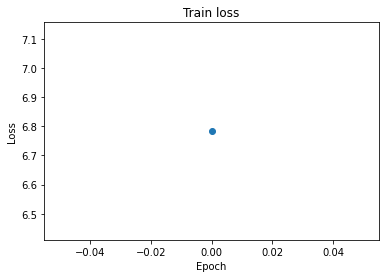

In [ ]:
plot_loss(train_loss, 'Train loss')

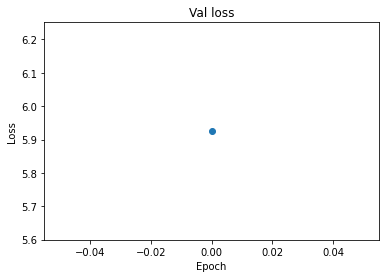

In [ ]:
plot_loss(val_loss, 'Val loss')

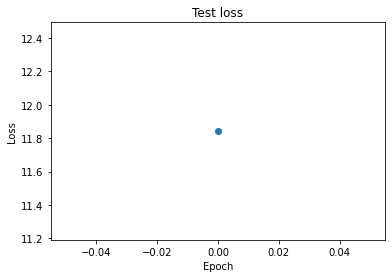

In [ ]:
plot_loss(test_loss, 'Test loss')

Метрики

In [ ]:
!pip install evaluate
!pip install jiwer
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 9.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 37.8 MB/s 
     |████████████████████████████████| 2.2 MB 67.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=6d4c4d1c44787459d1547f34bfb6a4a4f46f59832be6a797d9751c9da028d74a
  Stored in directory: /root/.cache/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge-score


In [ ]:
from evaluate import load


def get_tokens(model, val_iter):
    model.eval()
    pred_tokens, tgt_tokens = [], []

    for idx, (src, tgt) in (enumerate(valid_iter)):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]
        tgt_tokens.append(tgt[1:,:].reshape(-1))
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                                    src_padding_mask, tgt_padding_mask, src_padding_mask)

        _, pred_tks = torch.max(logits.reshape(-1, logits.shape[-1]).cpu(), dim = 1)
        pred_tokens.append(pred_tks)

    return pred_tokens, tgt_tokens 

In [ ]:
metric_folders = ['bleu', 'rouge']
def get_metrics(curr_iter, name):
    res = []
    path_to_dir = os.path.join(PATH, 'models')
    for idx in range(len(os.listdir(path_to_dir))):
        tmp = []
        model2path = os.path.join(path_to_dir, f'_{idx}.pt')
        print(model2path)
        _model = transformer.to(device)
        _model.load_state_dict(torch.load(model2path, map_location=device))
        _pred_tokens, _tgt_tokens = get_tokens(_model, curr_iter)

        translations = []
        for pr, tg in zip(_pred_tokens, _tgt_tokens):
            translations.append((tt_tokenizer.decode(pr, skip_special_tokens=True), tt_tokenizer.decode(tg, skip_special_tokens=True)))

        _predictions = [item[0] for item in translations]
        _references = [item[1] for item in translations]

        rouge = load('rouge')
        _results_rouge = rouge.compute(predictions=_predictions,
                            references=_references,
                            tokenizer=lambda x: x.split())
        
        bleu = load("bleu")

        _results_bleu = bleu.compute(predictions=_predictions, references=_references)

        with open(f'{os.path.join(PATH, metric_folders[1])}_{name}.txt', '+a') as f:
                    f.write(str(_results_rouge) + '\n')

        with open(f'{os.path.join(PATH, metric_folders[0])}_{name}.txt', '+a') as f:
            f.write(str(_results_bleu) + '\n')

        res.append([_results_rouge, _results_bleu])

    return res

In [ ]:
test_name, val_name = 'test_set', 'val_set'

In [ ]:
metrcis_test = get_metrics(test_iter, test_name)
metrcis_valid = get_metrics(valid_iter, val_name)

/content/drive/MyDrive/test_prikol/models/_0.pt


/content/drive/MyDrive/test_prikol/models/_0.pt


In [ ]:
def get_bleu(name_file):
    bleu_score = []
    with open(f'{os.path.join(PATH, metric_folders[0])}_{name_file}.txt', 'r') as f:
        print(f'{os.path.join(PATH, metric_folders[0])}_{name_file}.txt')
        for line in f:
            print(line[len("'bleu': "):len("'bleu': ")+7])
            bleu_score.append(float(line[len("'bleu': "):len("'bleu': ")+7]))
    return bleu_score


def get_rouge(name_file):
    # rouge1 - относится к перекрытию униграмм между полученным переводом и эталонным переводом
    # rouge2 - относится к перекрытию биграмм между полученным переводом и эталонным переводом
    # rougeL - измеряет самую длинную совпадающую последовательность слов
    rouge_score_1 = []
    with open(f'{os.path.join(PATH, metric_folders[1])}_{name_file}.txt', 'r') as f:
        print(f'{os.path.join(PATH, metric_folders[1])}_{name_file}.txt')
        for line in f:
            print(line[len("{'rouge1': "):len("{'rouge1': ")+7])
            rouge_score_1.append(float(line[len("{'rouge1': "):len("{'rouge1': ")+7]))
    return rouge_score_1

In [ ]:
def PlotBleu(name):
    bleu_score = get_bleu(name)
    plt.plot([i for i in range(len(bleu_score))], bleu_score, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('BLEU score')

In [ ]:
def PlotRouge(name):
    rouge_score_1 = get_rouge(name)
    plt.plot([i for i in range(len(rouge_score_1))], rouge_score_1, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('ROUGE-1 score')

/content/drive/MyDrive/test_prikol/bleu_val_set.txt
 0.0057


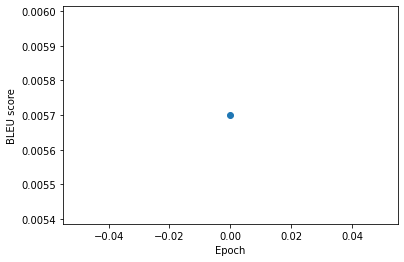

In [ ]:
PlotBleu(val_name)

/content/drive/MyDrive/test_prikol/bleu_test_set.txt
 0.0057


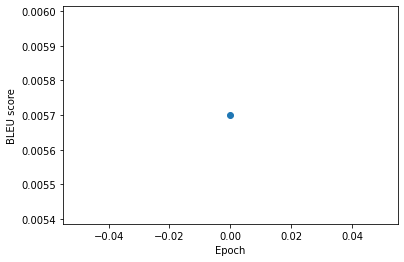

In [ ]:
PlotBleu(test_name)

/content/drive/MyDrive/test_prikol/rouge_val_set.txt
0.12560


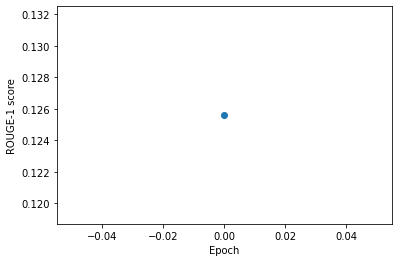

In [ ]:
PlotRouge(val_name)

/content/drive/MyDrive/test_prikol/rouge_test_set.txt
0.12560


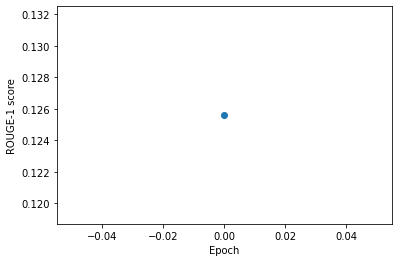

In [ ]:
PlotRouge(test_name)